In [56]:
import accelerate
import datasets
import evaluate
import numpy as np
import peft
import pickle
import pytest, ipytest
ipytest.autoconfig()
import pandas as pd
import transformers

from datasets import(
    load_dataset, 
    load_dataset_builder,
    get_dataset_split_names,
    get_dataset_config_names,
)


from peft import(
    LoftQConfig,
    LoraConfig,
    get_peft_model,
)

from transformers import(
AutoModelForCausalLM,
AutoTokenizer,
BitsAndBytesConfig,
TrainingArguments,
Trainer)
from trl import SFTTrainer, SFTConfig
# allows fast processing of datasets

In [3]:
ds_builder1=load_dataset_builder("LongSafari/open-genome", "stage1")
print(ds_builder1.info.features)
ds_builder2=load_dataset_builder("LongSafari/open-genome", "stage2")
print(ds_builder2.info.features)
ds_builder3=load_dataset_builder("LongSafari/open-genome", "sample")
print(ds_builder3.info.features)

{'record': Value(dtype='string', id=None), 'text': Value(dtype='string', id=None)}
{'text': Value(dtype='string', id=None)}
{'text': Value(dtype='string', id=None)}


In [4]:
ds_gs=load_dataset("LongSafari/open-genome", "sample")
get_dataset_split_names("LongSafari/open-genome", "sample")

['validation']

In [5]:
ds_gst1_train=load_dataset("LongSafari/open-genome", "stage1", split="train[:500]")
#print(ds_gst1[50])
ds_gst1_test=load_dataset("LongSafari/open-genome", "stage1", split="test[:50]")
print(get_dataset_split_names("LongSafari/open-genome", "stage1"))
ds_gst2_train=load_dataset("LongSafari/open-genome", "stage2", split="train[:500]")
ds_gst2_test=load_dataset("LongSafari/open-genome", "stage2", split="test[:50]")
print(get_dataset_split_names("LongSafari/open-genome", "stage2"))

['train', 'validation', 'test']
['train', 'validation', 'test']


In [16]:
print(ds_gst1_test[0])

{'record': 'JAHFAU010000168.1', 'text': 'CTCCTCGGCCAGCAAGCGCATCGTGAGAACCGGACTGACGATCAGCAAAACGGTCGCCAGCGGGCCCAATACCATGCGGCCATCCGGGTTCATCTGGCCGGTCGGCAGGCCAAAGTTAACGTTTAGGGAGAAGATCAGGCCGAGCACCAGGAAGCTGAGGGCGGCGGCCGCGTAAGCCAGCGGCGACACGAAGTAGCGGCGGAACTCGCGCACTGCAATAACCCAGCTGGTGCGCACGATCTAGCTCTCCTGCGGCACGACTTGCTCTTCCTCGCGAGTCAGCAGCAGGAAGATGCTTTCCAGGCTGACCCCGGCCGTTGTCAGCTCCAGCAAGTCCAGATCGGCTTCAACGATGCGGCGCGCCAACAGCGGGCGCAGGTCGCGGCCGGGCGAAGAGATCACCTCCACGGTGCCTGCCTGCCCGGCAAGCTCGACCGACTCCACTCCCGGGACGGACTTGAGCAGGTCGACCAGATCGGCTGCCGGGGCAGAGCTGCGGATCAGAATCCGGTACGCACCGGCCAGCTGGGCCGAAAGATTGGCGGGCGTATCTTCCGCCACCAACCGCCCCTTGTTGATAATCAGGACTCGATCACAAACTTGCTGTGCTTCCGAGAGGATGTGGGTGGACAACATGACGGTCCGCTCCCGCCCGAGCTCTCGGATTAAGTCCCGGACTTCGATGATTTGGGCCGGATCCAGTCCAATGGTCGGCTCGTCCAGGATCAAGACCTCGGGCCGGTGCAAGAGTGCCTGGGCCAGGCCGACCCGCTGTCGCAGACCTTTCGACAGGTTGCCAATCAGGCTATCACCGCGTTTTTCGAGGCCGACCTGCGTTAGGGATTCCTCGACCCGGCCATCCAGGTCCTCCACCCGCCGAAGCGAACCCATGAACGAGAGGTATTCGCGGCCGGACATCTCCGGGTACAGCGGGACGGTCTCCGGCAGGTATCCGACCC

In [6]:
def model_from_pkl(model):
    with open("pkl_files/" + model + ".pkl", "rb") as f:
        pkl_model=pickle.load(f)
    model_name=pkl_model["model_name"]
    tokenizer=pkl_model["tokenizer"]
    tokenizer.pad_token=tokenizer.eos_token
    return model_name, tokenizer

In [7]:
%%ipytest -k imp
#test to check models are properly improted from pkl files
def test_model_imp():
    lla_321, lla_321_tokenizer=model_from_pkl("Llama-3.2-1B")
    assert type(lla_321)==transformers.models.llama.modeling_llama.LlamaForCausalLM and type(lla_321_tokenizer)==transformers.tokenization_utils_fast.PreTrainedTokenizerFast
          

.                                                                                            [100%]
1 passed in 3.46s


In [8]:
lla_321, lla_321_tokenizer=model_from_pkl("Llama-3.2-1B")

In [10]:
lla_323, lla_323_tokenizer=model_from_pkl("Llama-3.2-3B")

In [9]:
mistral, mistral_tokenizer=model_from_pkl("Mistral-7B-Instruct-v0.1")

In [127]:
# perform preprocessing on the genomic data
def map_data(data, model, tokenizer):
    def tokenize_l_function(examples):
        return tokenizer(examples["text"], padding="max_length", truncation=True)
    def tokenize_m_function(examples):
        return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=1024)
        
    if type(model)==transformers.models.llama.modeling_llama.LlamaForCausalLM:
        tokenized_dataset=data.map(tokenize_l_function, batched=True)
    else:
        tokenized_dataset=data.map(tokenize_m_function, batched=True)
    return tokenized_dataset

In [128]:
l_tokenized_genome_samples=map_data(ds_gs, lla_321, lla_321_tokenizer)
m_tokenized_genome_samples=map_data(ds_gs, mistral, mistral_tokenizer)

Map: 100%|██████████████████| 50/50 [00:00<00:00, 224.28 examples/s]


In [129]:
l_tokenized_stage1_train=map_data(ds_gst1_train, lla_321, lla_321_tokenizer)
l_tokenized_stage1_test=map_data(ds_gst1_test, lla_321, lla_321_tokenizer)

In [14]:
l_tokenized_stage2_train=map_data(ds_gst2_train, lla_321, lla_321_tokenizer)
l_tokenized_stage2_test=map_data(ds_gst2_test, lla_321, lla_321_tokenizer)

In [130]:
m_tokenized_stage1_train=map_data(ds_gst1_train, mistral, mistral_tokenizer)
m_tokenized_stage1_test=map_data(ds_gst1_test, mistral, mistral_tokenizer)

Map: 100%|██████████████████| 50/50 [00:00<00:00, 669.82 examples/s]


In [16]:
m_tokenized_stage2_train=map_data(ds_gst2_train, mistral, mistral_tokenizer)
m_tokenized_stage2_test=map_data(ds_gst2_test, mistral, mistral_tokenizer)

In [17]:
# before loading in the base model with LoRA, might be good to define a helper function
# this looks at the total parameters a model has, and how many are trainable
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

In [32]:
training_args=TrainingArguments(output_dir="test_trainer", 
                                eval_strategy="epoch", 
                                per_device_train_batch_size=8,
                                num_train_epochs=3, # total number of training epochs to perform)
                                learning_rate=2e-4,
                                weight_decay=0.1,
                                logging_strategy="steps",
                                logging_steps=2)
# eval_strategy=epoch ensures that the evaluation metric will be reported at the end of each epoch
# this helps us monitor evaluation metrics during fine-tuning

# an epoch is one full cycle through a training dataset
# during the epoch, the model sees and learns from all the training examples
# steps are one optimization update
# during a step, parameters are updated based on a batch of training data
#the number of steps per epoch is the total number of training samples divided by batch size
# here we have 3 epochs, 48 steps, 16 steps per epoch
# epochs are best used when you want the model to see the dataset several times, 
 #steps are best used for larger datasets to ensure updates

In [19]:
# A trainer needs to be passed a function from the Evaluate library (specifically the accuracy function) to compute and report metrics
metric=evaluate.load("accuracy")

In [131]:
# the compute_metrics method will calculate prediction accuracy
comp_metrics_output=[]
def compute_metrics(eval_pred):
    logits=eval_pred.predictions
    refs=eval_pred.label_ids
    log_32=logits.astype(np.int32)
    log_32=np.concatenate(log_32).tolist()
    ref_32=refs.astype(np.int32)
    ref_32=np.concatenate(ref_32).tolist()
    predictions = np.argmax(log_32, axis=-1)
    met=metric.compute(predictions=predictions, references=ref_32)
    comp_metrics_output.append(met)
    return met
    # this lets us convert logits (returned by models) into predictions
    # np.argmax returns the indices of the maximum values along the axis of an array
    # axis=-1 means it looks at the last axis in the array
    # metric.compute gathers all cached predictions and references to compute the metric scor

In [132]:
# to fine-tune with LoRA, instantiate a base model (as above)
# create LoraConfig where LoRA-specific parameters are defined
config=LoraConfig(
    #inference_mode=False,
    r=8, #rank of update matrices, lower value results in smaller matrices with fewer parameters
    lora_alpha=16, #LoRA scaling factor
    task_type="CAUSAL_LM",
    lora_dropout=0.1, # dropout probability of LoRA layers
    bias="none", # specifies if bias parameters should be trained
    #modules_to_save=["decode_head"] #models apart from LoRA layers that are trainable
)

In [133]:
# the trainer object specifies the model, training arguments, training and test datasets, and evaluation function
def make_trainer(m_model, train_data, test_data, args):
    trainer=SFTTrainer(
        model=m_model,
        train_dataset=train_data,
        eval_dataset=test_data,
        peft_config=config,
        args=args,
        compute_metrics=compute_metrics,
        )
    # else:
    #     trainer=SFTTrainer(
    #         model=m_model,
    #         train_dataset=train_data,
    #         eval_dataset=test_data,
    #         peft_config=config,
    #         tokenizer=tokenizer,
    #         args=args,
    #         compute_metrics=compute_metrics,
    #     )
    return trainer
    
# SFTTrainer is best used for training with a pre-trained model and a smaller dataset
# It can be better suited for fine-tuning than regular Trainer


In [134]:
mis_lora_model=get_peft_model(mistral, config)
print_trainable_parameters(mis_lora_model)

trainable params: 3407872 || all params: 7245139968 || trainable%: 0.05


In [135]:
m_trainer = make_trainer(mis_lora_model, m_tokenized_stage1_train, m_tokenized_stage1_test,
                          SFTConfig(output_dir="test_trainer", eval_strategy="steps",
                                    logging_strategy="steps", 
                                    logging_steps=6, do_eval=True, 
                                    #max_length=1024,
                                    per_device_eval_batch_size=8,
                                   fp16=True))

# Using the SFTConfig default values provides us with...
# num_train_epochs = 3.0
# eval_strategy: typing.Union[transformers.trainer_utils.IntervalStrategy, str] = 'no'
# per_device_train_batch_size = 8
# learning_rate = 2e-5
# gradient_checkpointing=False

Truncating train dataset: 100%|█| 500/500 [00:00<00:00, 2677.62 exam
Truncating eval dataset: 100%|█| 50/50 [00:00<00:00, 5833.04 example


In [99]:
m_trainer.state.log_history

[]

In [136]:
m_trainer.train()

/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
6,0.652600,2.571135,0.027148
12,0.644100,2.527507,0.026348
18,0.631700,2.499065,0.027734
24,0.630200,2.482689,0.028398
30,0.626700,2.473098,0.028086
36,0.624000,2.467157,0.027891
42,0.620800,2.463838,0.027969
48,0.623100,2.462873,0.028438


/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch

TrainOutput(global_step=48, training_loss=0.6316352883974711, metrics={'train_runtime': 1594.9454, 'train_samples_per_second': 0.94, 'train_steps_per_second': 0.03, 'total_flos': 6.5563250393088e+16, 'train_loss': 0.6316352883974711})

,loss,eval_loss,eval_accuracy
step,,,
6,0.6526,2.571135,0.027148
12,0.6441,2.527507,0.026348
18,0.6317,2.499065,0.027734
24,0.6302,2.482689,0.028398
30,0.6267,2.473098,0.028086
36,0.6240,2.467157,0.027891
42,0.6208,2.463838,0.027969
48,0.6231,2.462873,0.028438


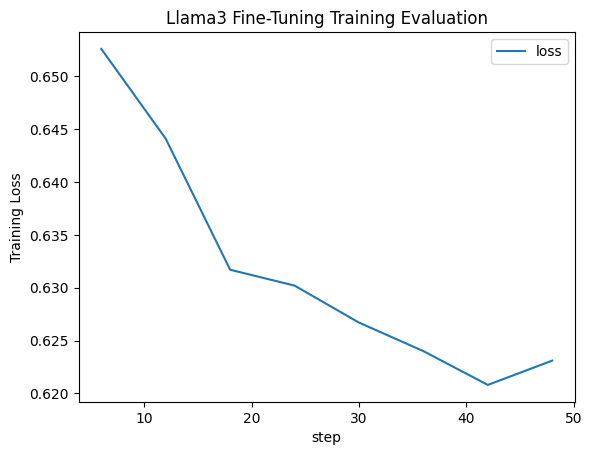

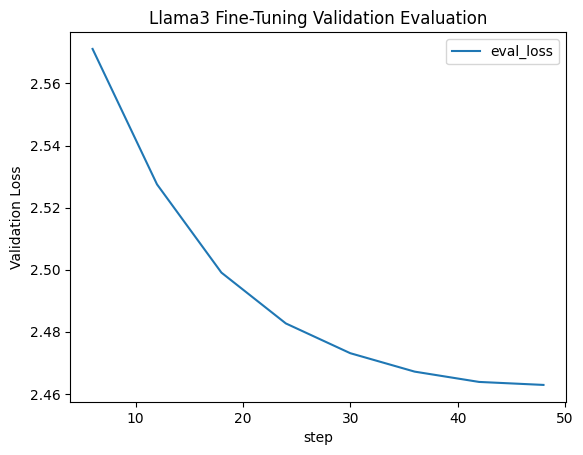

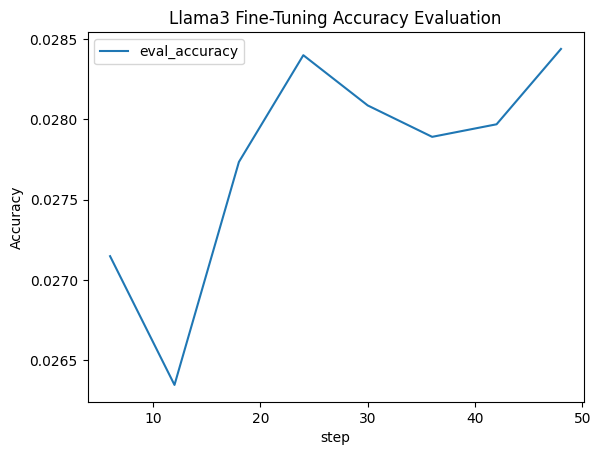

In [142]:
output=get_training_output(m_trainer, ['loss', 'eval_loss', 'eval_accuracy'])
output

In [ ]:
m2_trainer = make_trainer(mis_lora_model, m_tokenized_stage1_train, m_tokenized_stage1_test,
                          SFTConfig(output_dir="test_trainer", eval_strategy="steps",
                                    logging_strategy="steps",
                                    logging_steps=6))

In [36]:
lla_lora_model=get_peft_model(lla_321, config)
print_trainable_parameters(lla_lora_model)

trainable params: 851968 || all params: 1236666368 || trainable%: 0.07


In [66]:
l_trainer=make_trainer(lla_lora_model, l_tokenized_stage1_train, l_tokenized_stage1_test,
                          SFTConfig(output_dir="test_trainer", eval_strategy="epoch",
                                    logging_strategy="steps",
                                    logging_steps=2))

In [ ]:
l2_trainer = SFTTrainer(
    model=lla_lora_model,
    train_dataset=l_tokenized_stage1_train,
    eval_dataset=l_tokenized_stage1_test,
    peft_config=config,
    args=training_args,
    compute_metrics=compute_metrics
)

In [67]:
l_trainer.train() #same arguments as m_trainer

/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.642500,2.572258,0.000215
2,0.644500,2.569842,0.000273
3,0.648900,2.568797,0.000352


/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=48, training_loss=0.6465414439638456, metrics={'train_runtime': 1121.7611, 'train_samples_per_second': 1.337, 'train_steps_per_second': 0.043, 'total_flos': 8976366305280000.0, 'train_loss': 0.6465414439638456})

## Training Loss
* Measures how well the models are performing on the training data, used to update parameters, decreases as model learns
* Too low means model may have overfit
## Validation Loss
* Measures how well the model is performing on the separate validation set (the test set in this case)
* Shows how well model generalizes to data it hasn't seen, if this increases while training loss decreases, there is overfitting
## Accuracy
* How often a correct outcome is predicted

In [71]:
def get_dataframe(training_output: list, strat):
    df=pd.DataFrame(training_output) # convert the imported list of dictionaries to a DataFrame
    df.index=df[strat] # the index of the dataframe is whatever evaluation strategy was used
    df=df.drop([strat], axis=1) # drop one column so there aren't two step/epoch columns
    df.plot(y=0, xlabel=strat, ylabel="Training Loss", title="Llama3 Fine-Tuning Training Evaluation") # plot training loss
    df.plot(y=1, xlabel=strat, ylabel="Validation Loss", title="Llama3 Fine-Tuning Validation Evaluation") # plot validation loss
    df.plot(y=2, xlabel=strat, ylabel="Accuracy", title="Llama3 Fine-Tuning Accuracy Evaluation") # plot accuracy
    # for all of the above plots, the evaluation strategy (the index) is the x-axis value
    return df

# Things to Examine
1. Scope in Python
2. The continue keyword
3. Why def is usually better than lambda
4. Thinking about types

In [141]:
def get_training_output(trainer, keys: list):
    trainer_info=[]
    temp_dict={}
    logs=trainer.state.log_history # get the logs from model training, these show training loss, accuracy, etc
    strat=trainer.args.eval_strategy # was this evaluated at steps or epochs
    if (strat=='epoch'):
        condition=lambda i: i['epoch'].is_integer() 
        # if evaluated at epochs, extract data at the points where epochs are whole numbers
        strat='epoch'
    elif (strat=='steps'):
        condition=lambda i: i['step']%trainer.args.logging_steps==0.0 
        # if evaluated at steps, evaluate at the point where the number of steps divides evenly by the training interval
        strat='step'
    for i in logs: # loop through training logs
        if (condition): # check the appropriate condition based on evaluation strategy
                for j in keys: # look at all the keys (usually training loss, validation loss, and accuracy)
                    if j in i:
                        temp_dict[j]=i[j] # at the value tied to each key to a placeholder dictionary
                if j in temp_dict: # if a key is already in the dictionary (you've found a value for a different step/epoch)
                    temp_dict[strat]=i[strat] # add the corresponding step/epoch number to the temp dictionary
                    trainer_info.append(temp_dict) # add the temp dictionary to the list with training information
                    temp_dict={} # clear the temp dictionary, new values with the same keys as the last can now be added
    training_output=get_dataframe(trainer_info, strat) # run this method to convert the list of dicts to a dataframe
    return training_output #return the dataframe

,loss,eval_loss,eval_accuracy
epoch,,,
1.0,0.6425,2.572258,0.000215
2.0,0.6445,2.569842,0.000273
3.0,0.6489,2.568797,0.000352


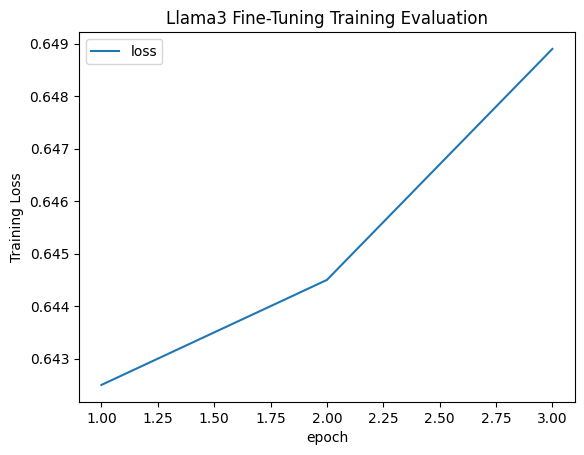

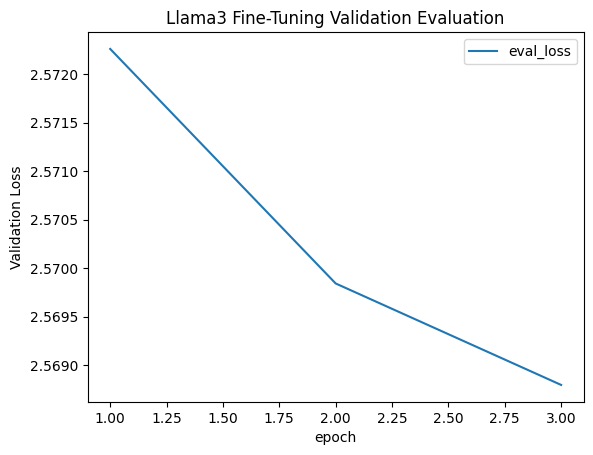

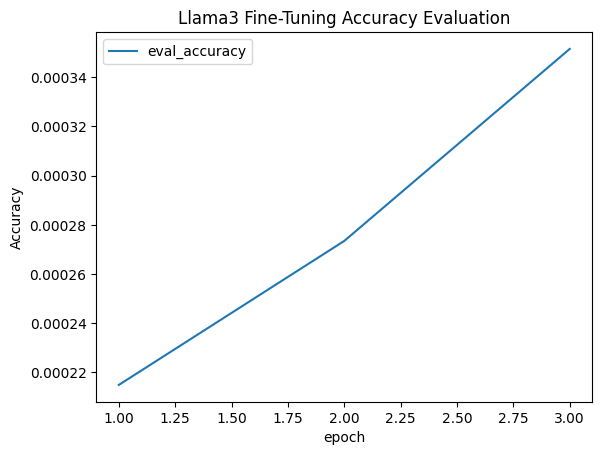

In [72]:
output=get_training_output(l_trainer, ['loss', 'eval_loss', 'eval_accuracy'])
output

In [62]:
#l_trainer.args.eval_strategy
l_trainer.state.log_history

[{'loss': 0.645,
  'grad_norm': 0.026327069848775864,
  'learning_rate': 1.916666666666667e-05,
  'num_tokens': 65536.0,
  'mean_token_accuracy': 0.20407196879386902,
  'epoch': 0.125,
  'step': 2},
 {'loss': 0.6541,
  'grad_norm': 0.02893950045108795,
  'learning_rate': 1.8333333333333333e-05,
  'num_tokens': 131072.0,
  'mean_token_accuracy': 0.20043683052062988,
  'epoch': 0.25,
  'step': 4},
 {'loss': 0.6499,
  'grad_norm': 0.027468502521514893,
  'learning_rate': 1.7500000000000002e-05,
  'num_tokens': 196608.0,
  'mean_token_accuracy': 0.20423997938632965,
  'epoch': 0.375,
  'step': 6},
 {'loss': 0.6441,
  'grad_norm': 0.028248999267816544,
  'learning_rate': 1.6666666666666667e-05,
  'num_tokens': 262144.0,
  'mean_token_accuracy': 0.2145191803574562,
  'epoch': 0.5,
  'step': 8},
 {'loss': 0.6566,
  'grad_norm': 0.02852179855108261,
  'learning_rate': 1.5833333333333333e-05,
  'num_tokens': 327680.0,
  'mean_token_accuracy': 0.1976722851395607,
  'epoch': 0.625,
  'step': 10}]

<Axes: title={'center': 'Llama3 Fine-Tuning Evaluation'}, xlabel='Steps', ylabel='Training Loss'>

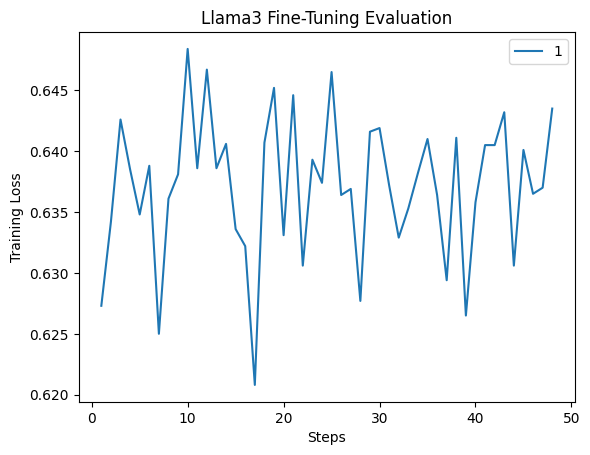

In [28]:
df_data=[[float(val) for val in line.split("\t")] for line in """
1 	0.627300
2 	0.634200
3 	0.642600
4 	0.638500
5 	0.634800
6 	0.638800
7 	0.625000
8 	0.636100
9 	0.638100
10 	0.648400
11 	0.638600
12 	0.646700
13 	0.638600
14 	0.640600
15 	0.633600
16 	0.632200
17 	0.620800
18 	0.640700
19 	0.645200
20 	0.633100
21 	0.644600
22 	0.630600
23 	0.639300
24 	0.637400
25 	0.646500
26 	0.636400
27 	0.636900
28 	0.627700
29 	0.641600
30 	0.641900
31 	0.637200
32 	0.632900
33 	0.635300
34 	0.638200
35 	0.641000
36 	0.636400
37 	0.629400
38 	0.641100
39 	0.626500
40 	0.635800
41 	0.640500
42 	0.640500
43 	0.643200
44 	0.630600
45 	0.640100
46 	0.636500
47 	0.637000
48 	0.643500
""".split("\n")[1:-1]]
df=pd.DataFrame(df_data)
#print(df)
# print(df[0]) #this is the first column of data, the number of steps taken
# print(df[1]) #this is the second column of data, training loss at each step
df.plot(x=0, y=1, xlabel="Steps", ylabel="Training Loss", title="Llama3 Fine-Tuning Evaluation")

In [ ]:
l2_trainer.train()

In [ ]:
# try a different version of llama3, see how this impacts performance
l2_tokenized_stage1_train=map_data(ds_gst1_train, lla_323, lla_323_tokenizer)
l2_tokenized_stage1_test=map_data(ds_gst1_test, lla_323, lla_323_tokenizer)

In [ ]:
ll2_lora_model=get_peft_model(lla_323, config)
print_trainable_parameters(ll2_lora_model)

In [ ]:
l23_trainer = SFTTrainer(
    model=ll2_lora_model,
    train_dataset=l2_tokenized_stage1_train,
    eval_dataset=l2_tokenized_stage1_test,
    peft_config=config,
    args=training_args,
    compute_metrics=compute_metrics
)
l23_trainer.train()